In [ ]:
# Read data from google drive 
from google.colab import drive
drive.mount('/content/drive')

import os
# path = '/content/drive/MyDrive/projet_recherche'
path = '/content/drive/MyDrive/ENSIIE/M1/S4/PRR-Projet-Recherche/projet_recherche'
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from functions import MAPE, MSE, MAE, Call_Price_Heston, C_BS, imp_vol

from tensorflow import keras
import tensorflow as tf
from keras.models import model_from_json
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split



# Explore the data

In [ ]:
df = pd.read_csv("data/param2.csv")

In [ ]:
df.shape

(100000, 12)

In [ ]:
df.head()

,S,K,m,T,r,rho,kappa,gam,nu,V0,price,impl_vol
0,100.0,109.727579,0.911348,1.289351,0.012616,-0.341331,0.466980,0.570688,0.037302,0.470395,22.052446,0.557978
1,100.0,121.761607,0.821277,1.748494,0.003466,-0.184956,0.325467,0.269769,0.112852,0.493984,25.489026,0.619066
2,100.0,75.938311,1.316858,0.718012,0.015625,-0.786272,1.965432,0.464774,0.181610,0.135622,28.586334,0.421757
3,100.0,75.997247,1.315837,1.180228,0.041085,-0.777110,1.047442,0.168897,0.027497,0.346401,34.370636,0.468116
4,100.0,101.204579,0.988098,0.699343,0.021379,-0.694197,0.622226,0.649895,0.468941,0.066212,11.764919,0.349931


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff74a762c10>,
      dtype=object)

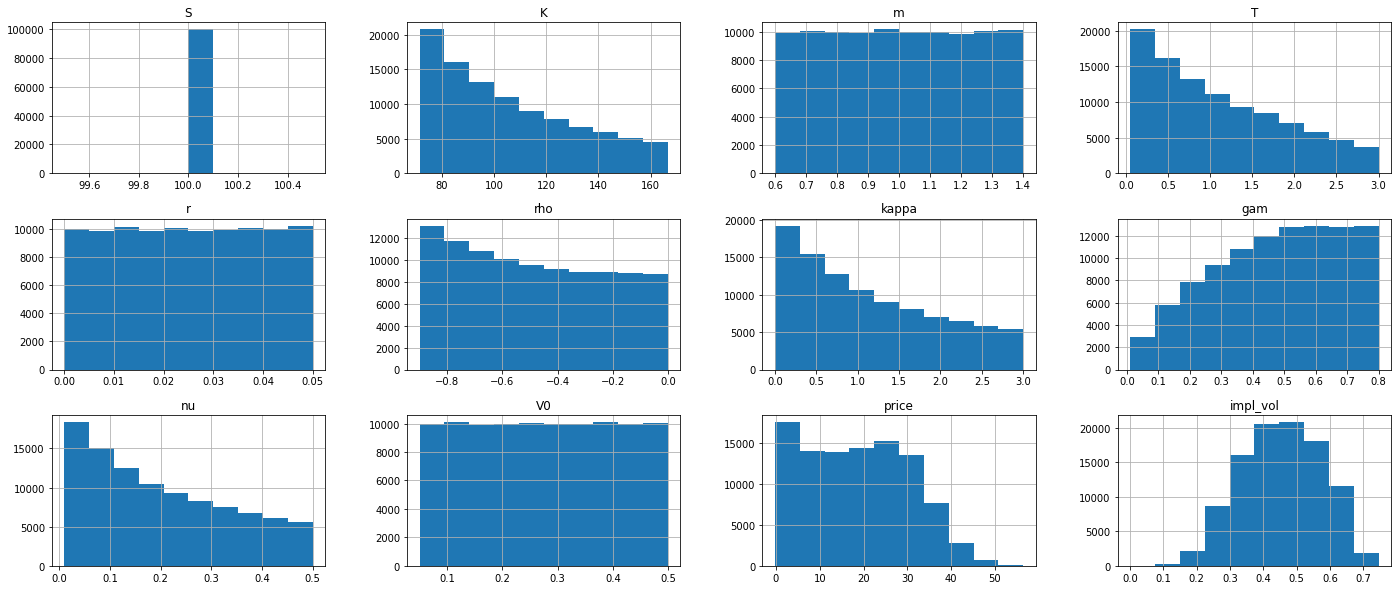

In [ ]:
# df.iloc[0:5].T.hist(bins=bins, sharey=True, layout=(1, 5), figsize=(12, 3))
df.hist(sharey=False, layout=(3, 4), figsize=(24, 10))

# Forward Pass

## Model predicting the price (model 1)

This first model predicts the price given the parameters of the Heston model. 

In [ ]:
X = df.drop(['K', 'S', 'price', 'impl_vol'], axis = 1)
# X_stand =(X-X.mean())/X.std()
y = df['price']
# y_norm = (y-y.mean())/y.std()
num_epochs = 8000

In [ ]:
X.head(5)

,m,T,r,rho,kappa,gam,nu,V0
0,0.911348,1.289351,0.012616,-0.341331,0.466980,0.570688,0.037302,0.470395
1,0.821277,1.748494,0.003466,-0.184956,0.325467,0.269769,0.112852,0.493984
2,1.316858,0.718012,0.015625,-0.786272,1.965432,0.464774,0.181610,0.135622
3,1.315837,1.180228,0.041085,-0.777110,1.047442,0.168897,0.027497,0.346401
4,0.988098,0.699343,0.021379,-0.694197,0.622226,0.649895,0.468941,0.066212


In [ ]:
# The dataset should be split into 10-validation, 10-testing, 80-training 
# However, to keep thing simple, we use just a 20-80 test-train split
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# train is now 80% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=1)

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)

In [ ]:
x_train.head()

,m,T,r,rho,kappa,gam,nu,V0
78689,1.057892,2.436148,0.032566,-0.838236,0.422797,0.095926,0.048776,0.310546
76423,0.949566,2.060128,0.023514,-0.683798,0.686401,0.713634,0.108075,0.478287
86945,1.285721,1.491172,0.038156,-0.885279,0.302047,0.626824,0.089107,0.195031
57427,0.765416,2.601210,0.044425,-0.310956,1.636165,0.260360,0.011851,0.132843
34616,1.338470,0.997576,0.047948,-0.752732,1.784894,0.728366,0.316334,0.360938


In [ ]:
y_train.head()

78689    32.796089
76423    26.314083
86945    33.990469
57427     6.397570
34616    37.317485
Name: price, dtype: float64

### model training

In [ ]:
# epochs is the number of iterations over the data
# verbose is a parameter to obtain additional information 
# Note: define the batch size to 
# Check if they use fully conected layers (dense) on the paper
initializer = tf.keras.initializers.GlorotUniform()
model1 = tf.keras.Sequential([
    keras.layers.Dense(units=200,input_shape=(8,),  kernel_initializer=initializer, activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=1),
    ])
model1.compile(optimizer='adam', 
               loss='mean_squared_error',
               metrics =[keras.metrics.MeanAbsoluteError(),
                         keras.metrics.MeanAbsolutePercentageError()])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 200)               1800      
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 200)               40200     
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 122,601
Trainable params: 122,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = datetime.datetime.now()
print("training start time:", start)
history1= model1.fit(x_train, y_train, epochs = num_epochs, batch_size= 1024, validation_data=(x_val, y_val), verbose=0)
end = datetime.datetime.now()
print("training end time:", end)
print('total time:', end-start)

training start time: 2022-05-18 18:04:11.913133


KeyboardInterrupt: ignored

In [ ]:
hist1 = history1.history

In [ ]:
results1 = model1.evaluate(x_test, y_test)

In [ ]:
for key in hist1.keys() :
  print(key, ':', hist1[key][num_epochs-1])

In [ ]:
for i in range(len(list(hist1.keys())[0:3])) :
  print(list(hist1.keys())[i], ':', results1[i])

### model predictions


In [ ]:
y_pred = model1.predict(x_test)

In [ ]:
y_test.head(10)

In [ ]:
y_pred[0:10]

In [ ]:
# MSE(y_test, y_pred)

In [ ]:
# MAE(y_test, y_pred)

In [ ]:
# MAPE(y_test, y_pred)

Saving the model history (metrics for every iteration)

In [ ]:
file_name = 'model1'
pd.DataFrame(hist1).to_csv('results/'+ file_name + '_train.csv', index = False)

Saving the model's prediction data for the test dataset

In [ ]:
temp = pd.DataFrame(y_test).rename(columns={'price':'y_test'})
temp['y_pred'] = y_pred
temp.to_csv('results/'+ file_name + '_pred.csv', index = False)

Saving the model's test evaluation

In [ ]:
pd.DataFrame(results1).transpose().set_axis(['loss', 'mean_absolute_error', 'mean_absolute_percentage_error'], axis=1).to_csv('results/'+ file_name +'_test.csv', index = False)

Saving the trained model so we are able to make predictions later 

In [ ]:
name = 'model1'
# serialize model to JSON
model_json = model1.to_json()
with open("results/"+ name + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("results/"+ name + ".h5")
print("Saved model to disk")

### Load the saved model

[example] Loading saved model to make predictions 

In [ ]:
name = 'model1'
# load json and create model
json_file = open('results/'+ name + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
# I'm using the same name as before to avoid confusion
model1 = model_from_json(loaded_model_json)
# load weights into new model
model1.load_weights("results/"+ name + ".h5")
print("Loaded model from disk")

# The model is recompiled to use kera's optimised structure
model1.compile(optimizer='adam', 
               loss='mean_squared_error',
               metrics =[keras.metrics.MeanAbsoluteError(),
                         keras.metrics.MeanAbsolutePercentageError()])

#  From this point on the model can be used normally to evaluate and predict 

Loaded model from disk


### Compare ANN with Heston pricing fct

Model predicted prices

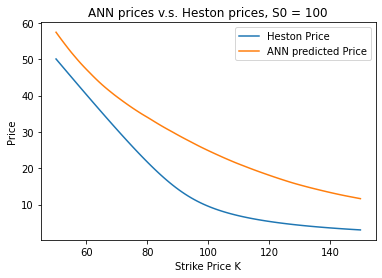

In [ ]:
S0 = 100
comp = pd.DataFrame(np.linspace(50, 150, 100), columns = ['K'])
comp['m'] = S0/comp['K']
comp['T'] = 1
comp['r'] = 0
comp['rho'] = 0.5
comp['kappa'] = 1
comp['gam'] = 0.08
comp['nu'] = 1
comp['V0'] = 0.08
comp['S'] = S0

y_comp = model1.predict(comp[x_test.columns])

comp['exact_price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], K = row['K'], T =  row['T'],  r =  row['r'], 
               kappa = row['kappa'], theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)


plt.plot(comp['K'], comp['exact_price'], label ="Heston Price" )
plt.plot(comp['K'], y_comp, label = "ANN predicted Price")
plt.xlabel("Strike Price K")
plt.ylabel("Price")
plt.title("ANN prices v.s. Heston prices, S0 = 100")
plt.legend()
plt.show()

Heston model prices

In [ ]:
# # K = np.linspace(50, 150, 100)
# # T = 1
# # m = S0/K
# # r = 0
# # rho = 0.5
# # kappa = 1
# # gam = 0.08
# # nu = 1
# # V0 = 0.08

# S0 = 100
# comp = pd.DataFrame(np.linspace(50, 150, 100), columns = ['K'])
# comp['m'] = S0/comp['K']
# comp['S'] = S0
# comp['T'] = 1
# comp['r'] = 0
# comp['rho'] = 0.5
# comp['kappa'] = 1
# comp['gam'] = 0.08
# comp['nu'] = 1
# comp['V0'] = 0.08


# comp['exact_price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], K = row['K'], T =  row['T'],  r =  row['r'], 
#                kappa = row['kappa'], theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)



# plt.plot(comp['K'], comp['exact_price'])
# plt.xlabel("Strike Price K")
# plt.ylabel("HestonPrice")
# plt.title("Heston prices with different strike K, S0 = 100")
# plt.show()

## Model predicting the implied volatility (model 2)

In [ ]:
X = df.drop(['price', 'K', 'S', 'impl_vol'], axis=1)
# X_stand =(X-X.mean())/X.std()
y = df['impl_vol']
# y_norm = (y-y.mean())/y.std()
num_epochs = 8000

In [ ]:
X.head(5)

,m,T,r,rho,kappa,gam,nu,V0
0,0.911348,1.289351,0.012616,-0.341331,0.466980,0.570688,0.037302,0.470395
1,0.821277,1.748494,0.003466,-0.184956,0.325467,0.269769,0.112852,0.493984
2,1.316858,0.718012,0.015625,-0.786272,1.965432,0.464774,0.181610,0.135622
3,1.315837,1.180228,0.041085,-0.777110,1.047442,0.168897,0.027497,0.346401
4,0.988098,0.699343,0.021379,-0.694197,0.622226,0.649895,0.468941,0.066212


In [ ]:
# The dataset should be split into 10-validation, 10-testing, 80-training 
# X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [ ]:
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# train is now 80% of the entire data set
# the _junk suffix means that we drop that variable completely
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=1)

# test is now 10% of the initial data set
# validation is now 10% of the initial data set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1)

### model training

In [ ]:
# epochs is the number of iterations over the data
# verbose is a parameter to obtain additional information 
# Note: define the batch size to 
initializer = tf.keras.initializers.GlorotUniform()
model2 = tf.keras.Sequential([
    keras.layers.Dense(units=200,input_shape=(8,),  kernel_initializer=initializer, activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=200,activation='relu'),
    keras.layers.Dense(units=1),
    ])
model2.compile(optimizer='adam', 
               loss='mean_squared_error',
               metrics =[keras.metrics.MeanAbsoluteError(),
                         keras.metrics.MeanAbsolutePercentageError()])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 200)               1800      
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dense_7 (Dense)             (None, 200)               40200     
                                                                 
 dense_8 (Dense)             (None, 200)               40200     
                                                                 
 dense_9 (Dense)             (None, 1)                 201       
                                                                 
Total params: 122,601
Trainable params: 122,601
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start = datetime.datetime.now()
print("training start time:", start)
history2= model2.fit(x_train, y_train, epochs=num_epochs, batch_size= 1024, validation_data=(x_val, y_val), verbose=0)
end = datetime.datetime.now()
print("training end time:", end)
print('total time:', end-start)

In [ ]:
hist2 = history2.history

In [ ]:
for key in hist2.keys() :
  print(key, ':', hist2[key][num_epochs-1])

In [ ]:
results2 = model2.evaluate(x_test, y_test)

In [ ]:
for key in hist2.keys() :
  print(key, ':', hist2[key][num_epochs-1])

In [ ]:
results2 = model2.evaluate(x_test, y_test)

In [ ]:
for i in range(len(list(hist2.keys())[0:3])) :
  print(list(hist2.keys())[i], ':', results2[i])

### model predictions


In [ ]:
# y_pred = model.predict(x_test)
y_pred = model2.predict(x_test)

In [ ]:
y_test.head()

In [ ]:
y_pred[0:5]

In [ ]:
MAPE(y_test, y_pred)

In [ ]:
MSE(y_test, y_pred)

In [ ]:
MAE(y_test, y_pred)

Saving the model history (metrics for every iteration)

In [ ]:
file_name = 'model2'
pd.DataFrame(hist2).to_csv('results/'+ file_name + '_train.csv', index = False)

Saving the model's prediction data for the test dataset

In [ ]:
temp = pd.DataFrame(y_test).rename(columns={'price':'y_test'})
temp['y_pred'] = y_pred
temp.to_csv('results/'+ file_name + '_pred.csv', index = False)

Saving the model's test evaluation

In [ ]:
pd.DataFrame(results2).transpose().set_axis(['loss', 'mean_absolute_error', 'mean_absolute_percentage_error'], axis=1).to_csv('results/'+ file_name +'_test.csv', index = False)

Saving the trained model so we are able to make predictions later 

In [ ]:
name = 'model2'
# serialize model to JSON
model_json = model2.to_json()
with open("results/"+ name + ".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("results/"+ name + ".h5")
print("Saved model to disk")

### Load the saved model

[example] Loading to saved model to make predictions 

In [ ]:
name = 'model2'
# load json and create model
json_file = open('results/'+ name + '.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model2 = model_from_json(loaded_model_json)
# load weights into new model
model2.load_weights("results/"+ name + ".h5")
print("Loaded model from disk")

# The model is recompiled to use kera's optimised structure
model2.compile(optimizer='adam', 
               loss='mean_squared_error',
               metrics =[keras.metrics.MeanAbsoluteError(),
                         keras.metrics.MeanAbsolutePercentageError()])

#  From this point on, the model can be used normally to evaluate and predict 

Loaded model from disk


## Test 

Test with fixed values to compare ANN with the Heston price values (prices or vol) of Heston model

In [ ]:
# comp[x_test.columns]

### implied vol - in the bounds

ANN vol

In [ ]:
# parameters in the article (sect. 4.1.1) 
S0 = 100
comp = pd.DataFrame(np.linspace(50, 150, 100), columns = ['K'])
comp['m'] = S0/comp['K']
comp['T'] = 2
comp['r'] = 0.05
comp['rho'] = 0.3 # -0.75
comp['kappa'] = 0.1
comp['gam'] = 0.1
comp['nu'] = 0.1
comp['V0'] = 0.05


y_comp = model2.predict(comp[x_test.columns])
comp['ANN_vol'] = y_comp

# plt.plot(comp['K'], y_comp)
# plt.xlabel("Strike Price K")
# plt.ylabel("ANN predicted implied volatility")
# plt.title("ANN predicted implied vol with different strikes K")
# plt.show()

BS vol

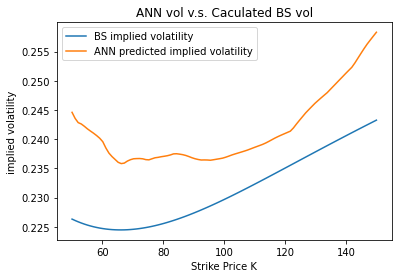

In [ ]:
comp['S'] = S0
comp['Heston_price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], K = row['K'], T =  row['T'],  r =  row['r'], 
               kappa = row['kappa'], theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)

comp['BS_vol'] = comp.apply(lambda row : imp_vol(row['Heston_price'], r=row['r'], 
                  S=row['S'], T=row['T'], K=row['K']), axis = 1)



plt.plot(comp['K'], comp['BS_vol'], label = "BS implied volatility")
plt.plot(comp['K'], y_comp, label = "ANN predicted implied volatility")
plt.xlabel("Strike Price K")
plt.ylabel("implied volatility")
plt.title("ANN vol v.s. Caculated BS vol")
plt.legend()
plt.show()

VERY GOOD !!!

ANN is more sensitive in predicting vol than prices. Nearly all prices are well predicted but not volatility.

The prediction has same form than Heston price values but don't go well in details.

Predicting the price using vol is more precise than using ANN_price directly.

#### BS Prices corresponding to these vol

In [ ]:
comp['BS_ANN_price'] = comp.apply(lambda row : C_BS(sigma = row['ANN_vol'], r =  row['r'], 
                                               S = row['S'], T =  row['T'], K = row['K']), axis = 1)
# C_BS(sigma, r, S, T, K)

#### Heston Prices as market price

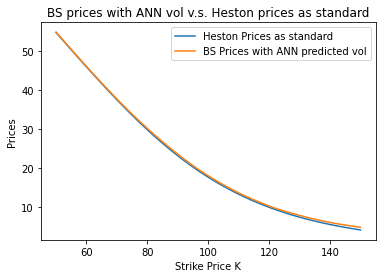

In [ ]:
plt.plot(comp['K'], comp['Heston_price'], label = "Heston Prices as standard")
plt.plot(comp['K'], comp['BS_ANN_price'], label = "BS Prices with ANN predicted vol")
plt.xlabel("Strike Price K")
plt.ylabel("Prices")
plt.title("BS prices with ANN vol v.s. Heston prices as standard")
plt.legend()
plt.show()

Same as Heston price, logique and correct !

### Implied vol - deep smile

In [ ]:
S0 = 100
comp = pd.DataFrame(np.linspace(10, 200, 100), columns = ['K'])
comp['m'] = S0 / comp['K']
comp['T'] = 1
comp['r'] = 0
comp['kappa'] = 1
comp['gam'] = 0.08
comp['nu'] = 1
comp['rho'] = 0.5
comp['V0'] = 0.08


y_comp = model2.predict(comp[x_test.columns])
comp['ANN_vol'] = y_comp
# import matplotlib.pyplot as plt 

# plt.plot(comp['K'],y_comp)
# plt.xlabel("Strike Price K")
# plt.ylabel("ANN Volatility")
# plt.title("ANN predicted implied vol with different strikes K (Deep smile)")
# plt.show()



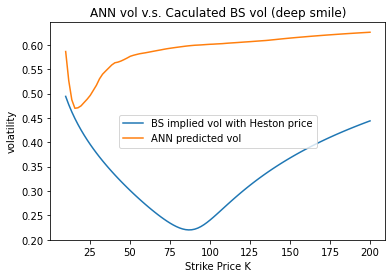

In [ ]:
comp['S'] = S0
comp['Heston_price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], K = row['K'], T =  row['T'],  r =  row['r'], 
               kappa = row['kappa'], theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)

comp['BS_vol'] = comp.apply(lambda row : imp_vol(row['Heston_price'], r=row['r'], 
                  S=row['S'], T=row['T'], K=row['K']), axis = 1)



plt.plot(comp['K'], comp['BS_vol'], label ="BS implied vol with Heston price" )
plt.plot(comp['K'], comp['ANN_vol'] , label="ANN predicted vol")
plt.xlabel("Strike Price K")
plt.ylabel("volatility")
plt.title("ANN vol v.s. Caculated BS vol (deep smile)")
plt.legend()
plt.show()

In a deep smile case, ANN performs badly.

#### BS Prices corresponding to these vol

In [ ]:
comp['BS_ANN_price'] = comp.apply(lambda row : C_BS(sigma = row['ANN_vol'], r =  row['r'], 
                                               S = row['S'], T =  row['T'], K = row['K']), axis = 1)
# C_BS(sigma, r, S, T, K)

In [ ]:
# plt.plot(comp1['K'], comp1['price'])
# plt.xlabel("Strike Price K")
# plt.ylabel("BS Prices")
# plt.title("BS Prices corresponding to ANN predicted vol")
# plt.show()

#### Heston Prices as market price

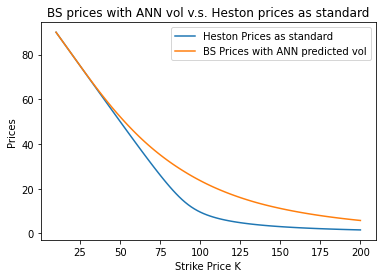

In [ ]:
plt.plot(comp['K'], comp['Heston_price'], label = "Heston Prices as standard")
plt.plot(comp['K'], comp['BS_ANN_price'], label = "BS Prices with ANN predicted vol")
plt.xlabel("Strike Price K")
plt.ylabel("Prices")
plt.title("BS prices with ANN vol v.s. Heston prices as standard")
plt.legend()
plt.show()

Same as Heston price, logique and correct !

### implied vol - out of bounds for Heston prices

/content/drive/.shortcut-targets-by-id/17nh9XZZxOhP9WHCy0vd_yx87AAthT6mc/projet_recherche/functions.py:54: RuntimeWarning: overflow encountered in cosh
  c=lambda x:(gamma(x)*np.cosh(0.5*T*gamma(x))/np.sinh(0.5*T*gamma(x))+b(x))
/content/drive/.shortcut-targets-by-id/17nh9XZZxOhP9WHCy0vd_yx87AAthT6mc/projet_recherche/functions.py:54: RuntimeWarning: invalid value encountered in cdouble_scalars
  c=lambda x:(gamma(x)*np.cosh(0.5*T*gamma(x))/np.sinh(0.5*T*gamma(x))+b(x))
/content/drive/.shortcut-targets-by-id/17nh9XZZxOhP9WHCy0vd_yx87AAthT6mc/projet_recherche/functions.py:54: RuntimeWarning: overflow encountered in sinh
  c=lambda x:(gamma(x)*np.cosh(0.5*T*gamma(x))/np.sinh(0.5*T*gamma(x))+b(x))
/content/drive/.shortcut-targets-by-id/17nh9XZZxOhP9WHCy0vd_yx87AAthT6mc/projet_recherche/functions.py:59: RuntimeWarning: invalid value encountered in cdouble_scalars
  h=lambda x:(-(x**2+i*x)*V0/c(x))
/content/drive/.shortcut-targets-by-id/17nh9XZZxOhP9WHCy0vd_yx87AAthT6mc/projet_recherche/func

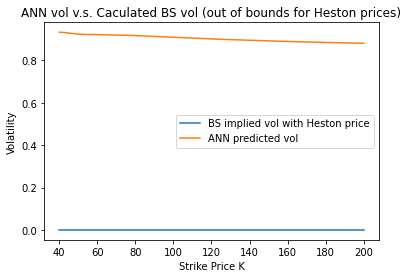

In [ ]:
# ANN vol
S0 = 100
comp = pd.DataFrame(np.linspace(40, 200, 100), columns = ['K'])
comp['m'] = S0 / comp['K']
comp['T'] = 10
comp['r'] = 0
comp['kappa'] = 1
comp['gam'] = 0.08
comp['nu'] = 1
comp['rho'] = 0.5
comp['V0'] = 0.08

y_comp = model2.predict(comp[x_test.columns])


# model vol
comp['S'] = S0
comp['price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], K = row['K'], T =  row['T'],  r =  row['r'], 
               kappa = row['kappa'], theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)

comp['vol'] = comp.apply(lambda row : imp_vol(row['price'], r=row['r'], 
                  S=row['S'], T=row['T'], K=row['K']), axis = 1)




import matplotlib.pyplot as plt 

plt.plot(comp['K'], comp['vol'], label ="BS implied vol with Heston price" )
plt.plot(comp['K'],y_comp, label = "ANN predicted vol")

plt.xlabel("Strike Price K")
plt.ylabel("Volatility")
plt.title("ANN vol v.s. Caculated BS vol (out of bounds for Heston prices)")
plt.legend()
plt.show()

ANN can be used to cases where traditional pricing fct can not have Heston fct solutions.

# Backward Pass

## Differential Evolution.

### try 1 - our financial model parameters

In [ ]:
# set default model parameters to verify calibration result.
S = 100
K = 110
m = np.linspace(0.85, 1.15, num=2)
T = np.linspace(0.5, 1.5, num=2)
r = 0.03

rho, kappa, gam, nu, V0 = 0.5, 1, 0.08, 1, 0.08

# rho = np.linspace(-0.75, -0.25, num=1) # 0.5 
# kappa = np.linspace(0.5, 1.0, num=1) # 1
# gam = np.linspace(0.3, 0.5, num=1) # 0.08
# nu = np.linspace(0.15, 0.35, num=1) # 1
# V0 = np.linspace(0.15, 0.35, num=1) # 0.08

In [ ]:
from itertools import product
comp = pd.DataFrame(list(product(m, T)), columns=['m', 'T'])

In [ ]:
# number of data 
S0 = 100

comp['S'] = S0
comp['K'] = S0/comp['m']
comp['r'] = r
comp['rho'] = rho
comp['kappa'] = kappa
comp['gam'] = gam
comp['nu'] = nu
comp['V0'] = V0
comp

,m,T,S,K,r,rho,kappa,gam,nu,V0
0,0.85,0.5,100,117.647059,0.03,0.5,1,0.08,1,0.08
1,0.85,1.5,100,117.647059,0.03,0.5,1,0.08,1,0.08
2,1.15,0.5,100,86.956522,0.03,0.5,1,0.08,1,0.08
3,1.15,1.5,100,86.956522,0.03,0.5,1,0.08,1,0.08


In [ ]:
# Calculation of price and implied_vol with given parameters

# price
# data_price = Call_Price_Heston(S,K,T,r,kappa,gam,nu,rho,V0,alpha=1,L=1000)
comp['price'] = comp.apply(lambda row : Call_Price_Heston(S = row['S'], 
      K = row['K'], T =  row['T'],  r =  row['r'], kappa = row['kappa'], 
      theta = row['gam'], nu = row['nu'], rho = row['rho'], V0 = row['V0']), axis = 1)

# volatility
# data = imp_vol(C=data_price, r=r, S=S, T=T, K=K)
comp['vol'] = comp.apply(lambda row : imp_vol(row['price'], r=row['r'], 
                  S=row['S'], T=row['T'], K=row['K']), axis = 1)

comp

,m,T,S,K,r,rho,kappa,gam,nu,V0,price,vol
0,0.85,0.5,100,117.647059,0.03,0.5,1,0.08,1,0.08,3.454216,0.307390
1,0.85,1.5,100,117.647059,0.03,0.5,1,0.08,1,0.08,8.576183,0.269946
2,1.15,0.5,100,86.956522,0.03,0.5,1,0.08,1,0.08,15.678025,0.228103
3,1.15,1.5,100,86.956522,0.03,0.5,1,0.08,1,0.08,20.461046,0.220393


In [ ]:
# x is a tensor of shape [n, m] while y is of shape [n].
# This objective function implements the ANN of the forward pass
# to get an implied volatility

def objective(X):
  # X = [rho, kappa, gam, nu, V0]
  m = 0.85
  T = 0.5
  S = 100 # underlying price
  K = S/m
  r = 0
  
  # param = [m, T, r, rho, kappa, gam, nu, V0]
  param = [m, T, r, X[0], X[1], X[2], X[3], X[4]]

  # weights = loaded_model2.get_weights()
  # single_item_model = create_model(batch_size=1)
  # single_item_model.set_weights(weights)
  # single_item_model.compile(compile_params)

  pred_vol = model2.predict(np.array(param).reshape(1,8)) # return a volatility

  # return np.array(param).reshape(1,8)
  # return pred_vol
  return np.mean((pred_vol[0][0] - np.array(comp['vol'][0]))**2) # MSE


In [ ]:
# x is a tensor of shape [n, m] while y is of shape [n].
# This objective function implements the Heston model for pricing
# and then computes the implied volatility of the price

def objective2(X):
  # X = [rho, kappa, gam, nu, V0]
  m = 0.85
  T = 0.5
  S = 100 # underlying price
  K = S/m
  r = 0
  
  # param = [m, T, r, rho, kappa, gam, nu, V0]
  param = [m, T, r, X[0], X[1], X[2], X[3], X[4]]

  # weights = loaded_model2.get_weights()
  # single_item_model = create_model(batch_size=1)
  # single_item_model.set_weights(weights)
  # single_item_model.compile(compile_params)

  price = Call_Price_Heston(S,K,T,r,X[1],X[2],X[3],X[0],X[4],alpha=1,L=1000) 
  pred_vol = imp_vol(price, r, S, T, K, N = 20) # returns implied volatility

  # return np.array(param).reshape(1,8)
  # return pred_vol
  return np.mean((pred_vol - np.array(comp['vol'][0]))**2) # MSE

In [ ]:
objective([rho, kappa, gam, nu, V0])

0.03827410198392356

In [ ]:
objective2([rho, kappa, gam, nu, V0])

3.771849493904513e-05

#### With default DE parameters

In [ ]:
from scipy.optimize import differential_evolution 
import numpy as np
import scipy 
import math

Be careful with searching intervals

In [ ]:
# Optimisation using the ANN
import time
start_time = time.time()

# 128.29 seconds 
# bounds inputs : (rho, kappa, gam, nu, V0) 
# exact values : 0.5	1	0.08	1	0.08	
bounds = [(0.2, 0.6), (0.8, 1.2), (0.05, 0.13), (0.8, 1.2), (0.05, 0.11)]
result_no_limit = scipy.optimize.differential_evolution(func = objective, bounds = bounds) 

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))
print(result_no_limit)

--- 128.29 seconds ---
     fun: 0.01143230302420169
     jac: array([0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 3318
     nit: 43
 success: True
       x: array([0.59873253, 0.80015351, 0.05040318, 0.80005308, 0.05003105])


In [ ]:
# Optimisation using the Heston model

import time
start_time = time.time()

# bounds inputs : (rho, kappa, gam, nu, V0) 
# exact values : 0.5	1	0.08	1	0.08	
bounds = [(0.2, 0.6), (0.8, 1.2), (0.05, 0.13), (0.8, 1.2), (0.05, 0.11)]
result_no_limit2 = scipy.optimize.differential_evolution(func = objective2, bounds = bounds) 

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))
print(result_no_limit)

--- 554.3 seconds ---
     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 16806
     nit: 223
 success: True
       x: array([0.32071084, 0.97231343, 0.05690639, 0.8070953 , 0.09097544])


#### With DE parameters in the paper

In [ ]:
# Optimisation using the ANN
import time
start_time = time.time()

# 526.92 seconds
# bounds inputs : (rho, kappa, gam, nu, V0)
bounds = [(0.2, 0.6), (0.8, 1.2), (0.05, 0.13), (0.8, 1.2), (0.05, 0.11)]
result_limited = scipy.optimize.differential_evolution(func = objective, bounds = bounds, 
     popsize = 50, strategy = 'best1bin', mutation = (0.5, 1), 
     recombination = 0.7, tol = 0.01)

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))
print(result_limited)

--- 526.92 seconds ---
     fun: 0.011426402346358592
     jac: array([0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 13524
     nit: 53
 success: True
       x: array([0.59742258, 0.8       , 0.05      , 0.80012182, 0.05000796])


In [ ]:
# Optimisation using the Heston model

import time
start_time = time.time()

# 526.92 seconds
# bounds inputs : (rho, kappa, gam, nu, V0)
bounds = [(0.2, 0.6), (0.8, 1.2), (0.05, 0.13), (0.8, 1.2), (0.05, 0.11)]
result_limited2 = scipy.optimize.differential_evolution(func = objective2, bounds = bounds, 
     popsize = 50, strategy = 'best1bin', mutation = (0.5, 1), 
     recombination = 0.7, tol = 0.01)

print("--- %s seconds ---" % (round(time.time() - start_time, 2)))
print(result_limited2)

--- 3244.49 seconds ---
     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 107506
     nit: 429
 success: True
       x: array([0.39606959, 0.9398332 , 0.06246068, 0.89132294, 0.08504063])


Probably they wrote their DE by hand... 
It's insane to get results less than 1s !!

In [ ]:
# Compare the results with initial values
# ANN

initial_value = np.array([0.5,	1,	0.08,	1,	0.08])
result = np.array([0.59873253, 0.80015351, 0.05040318, 0.80005308, 0.05003105])

(initial_value - result )/initial_value # in percentage

array([-0.19746506,  0.19984649,  0.36996025,  0.19994692,  0.37461187])

In [ ]:
# Compare the results with initial values
# Heston

initial_value = np.array([0.5,	1,	0.08,	1,	0.08])
result2 = np.array([0.39606959, 0.9398332 , 0.06246068, 0.89132294, 0.08504063])

(initial_value - result2 )/initial_value # in percentage

array([ 0.20786082,  0.0601668 ,  0.2192415 ,  0.10867706, -0.06300788])